<a href="https://colab.research.google.com/github/yoii18/KaggleModels/blob/main/IndianDiabetesDatabase_KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import data

In [3]:
data = pd.read_csv("/content/drive/MyDrive/Colab_Data/diabetes.csv")
data.head(2)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0


# Feature Definitions:
1. `Pregnancies`: Number of times someone was pregnant
2. `Glucose`: Plasma glucose concentration a 2 hours in an oral glucose tolerance test
3. `BloodPressure`: Diastolic blood pressure (mm Hg)
4. `SkinThickness`: Triceps skin fold thickness (mm)
5. `Insulin`: 2-Hour serum insulin (mu U/ml)
6. `BMI`: Body mass index (weight in kg/(height in m)^2)
7. `DiabetesPedigreeFunction`: Diabetes pedigree function
8. `Age`: Age (Years)
9. `Outcome`: Class variable (0 or 1) 268 of 768 are 1, the others are 0.


# Basic Information Gathering
We must gather some basic information regarding our dataset, this includes:
1. shape of our dataset
2. null values in our dataset
3. duplicate rows, if at all present
4. basic stats for both categorical and continuous features

In [4]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
data.shape

(768, 9)

In [6]:
data.duplicated().sum()

0

In [7]:
cols = list(data.columns)
# print(cols)
for i, col in enumerate(cols):
  print(f"Unique values in {col}: ", data[col].nunique())
# print("Unique values")

Unique values in Pregnancies:  17
Unique values in Glucose:  136
Unique values in BloodPressure:  47
Unique values in SkinThickness:  51
Unique values in Insulin:  186
Unique values in BMI:  248
Unique values in DiabetesPedigreeFunction:  517
Unique values in Age:  52
Unique values in Outcome:  2


We have our target variable that is categorical, other than that, there seems to be no categorical variables

In [8]:
cols = cols[:-1]

In [12]:
cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

In [9]:
data.describe().T.iloc[:-1, 1:]

,mean,std,min,25%,50%,75%,max
Pregnancies,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00


# EDA

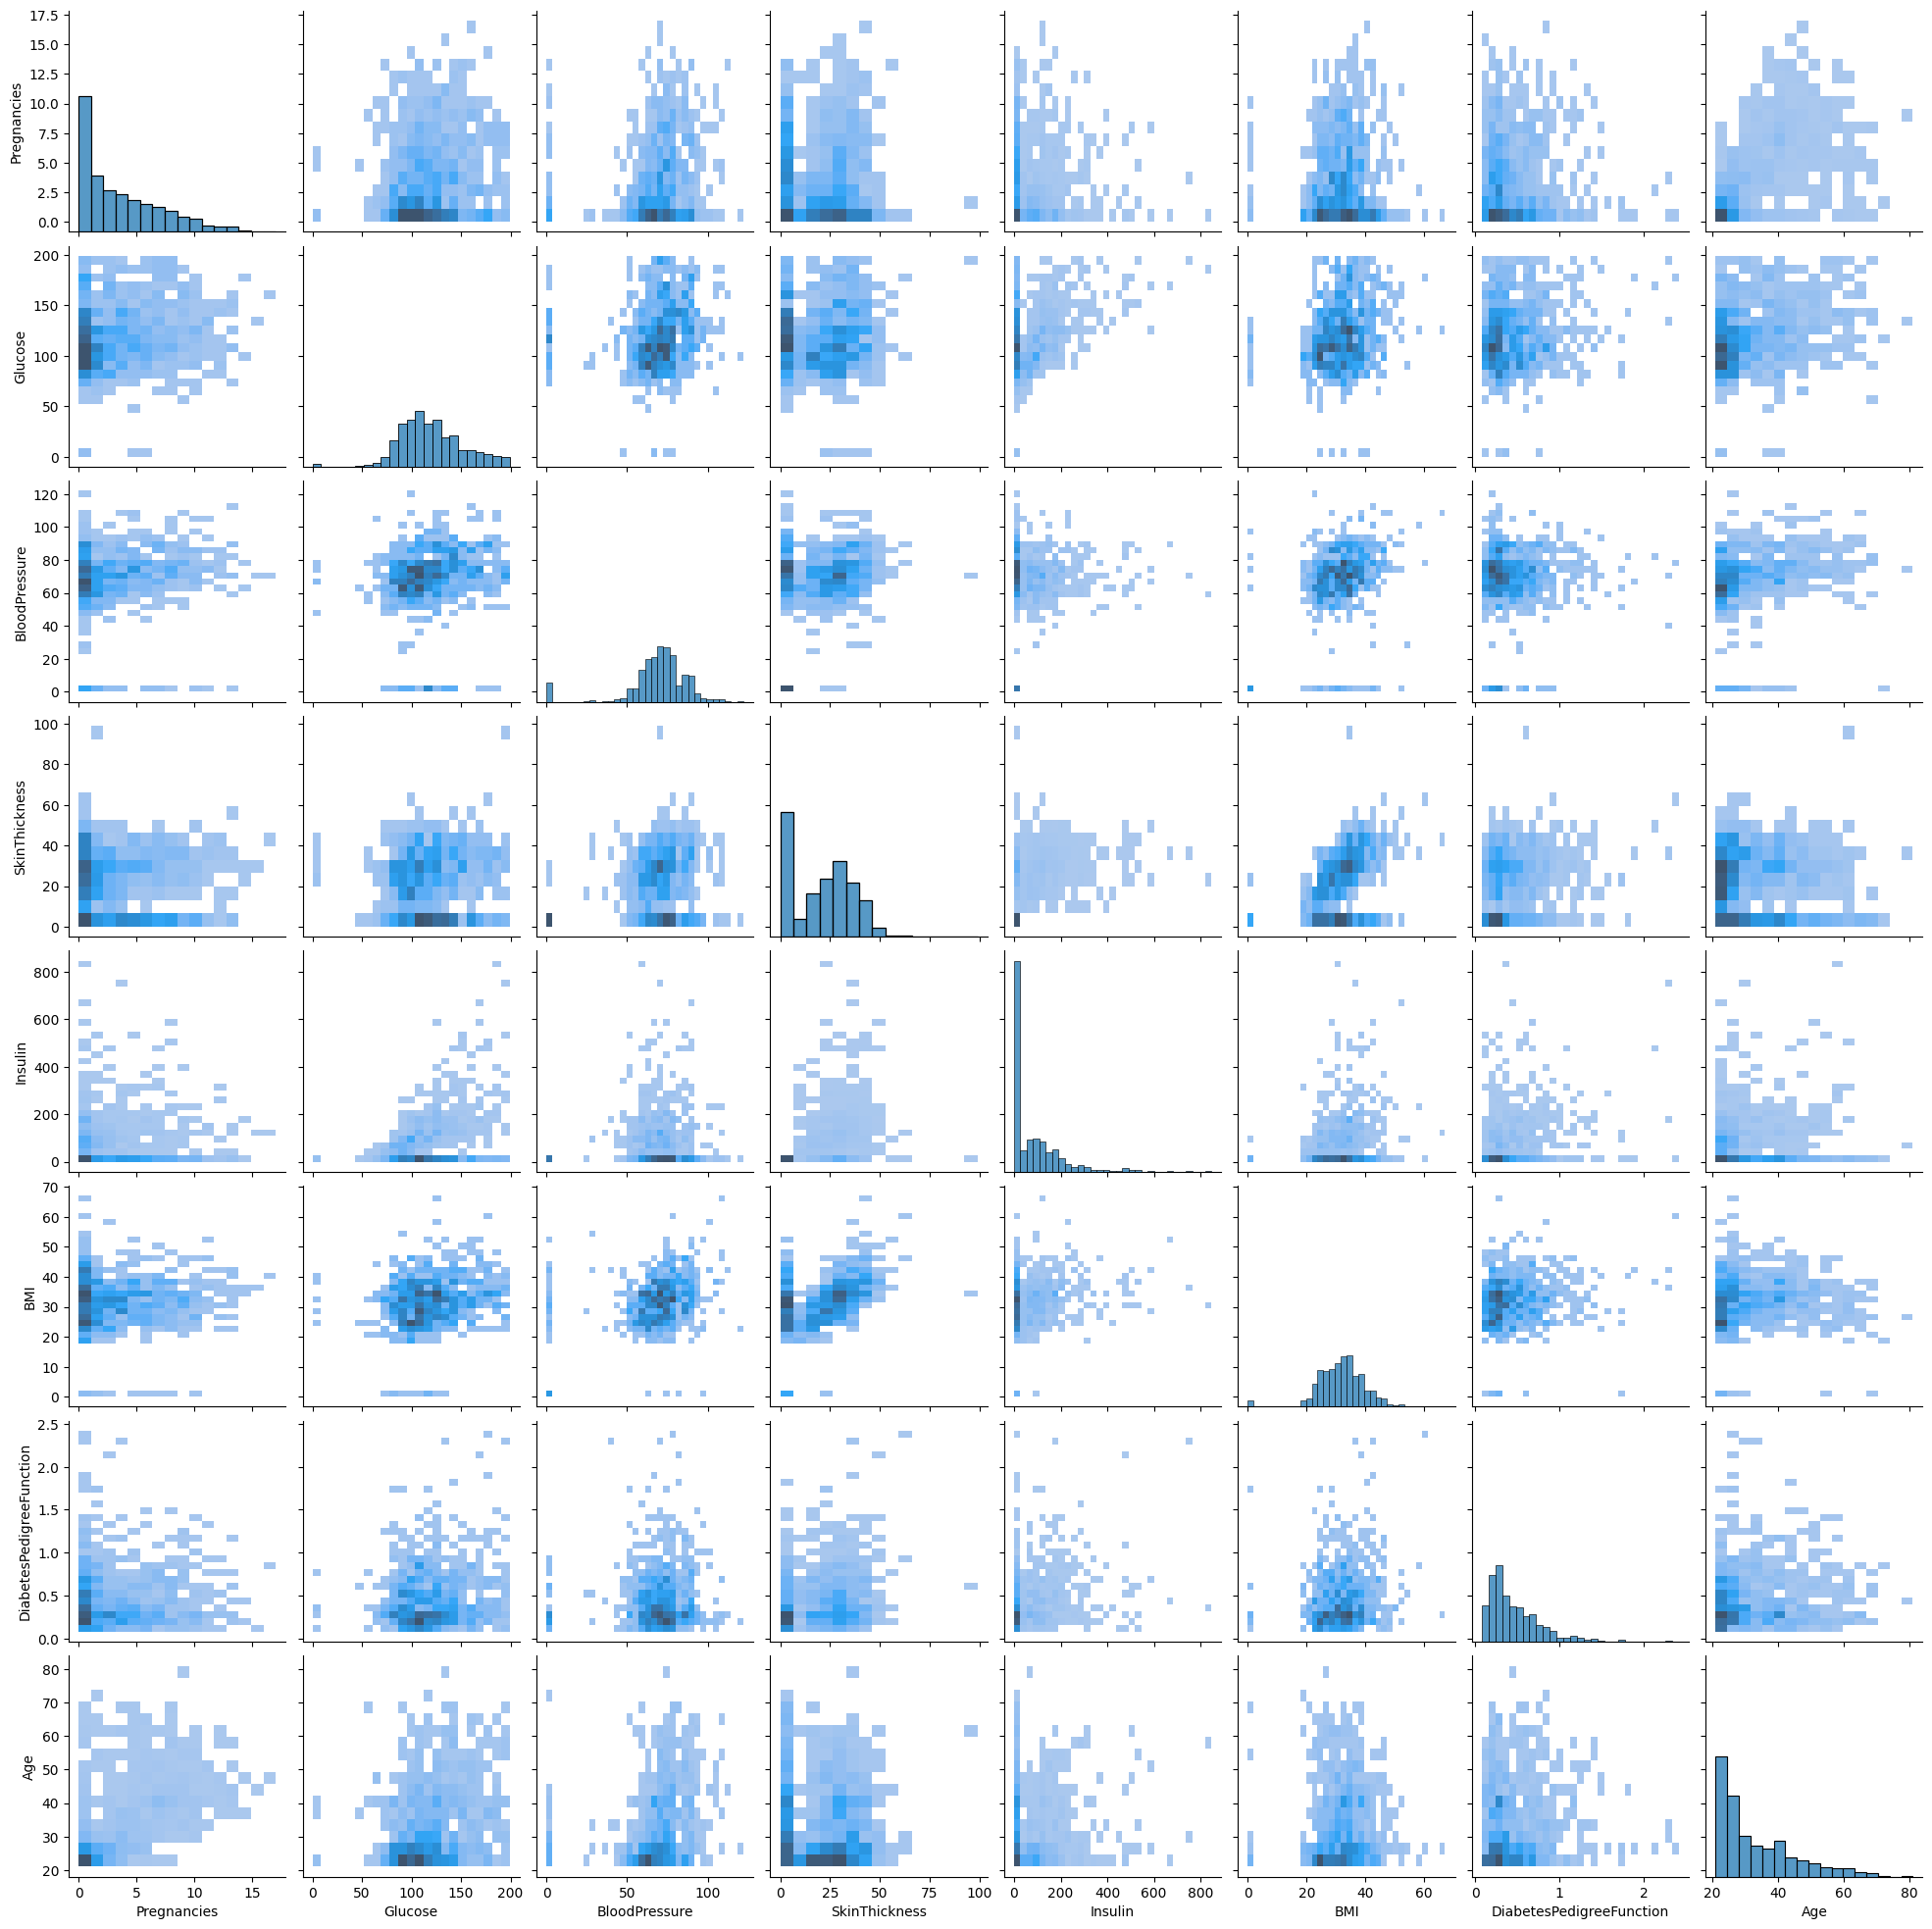

In [13]:
sns.pairplot(data, x_vars=cols, y_vars=cols, kind='hist')

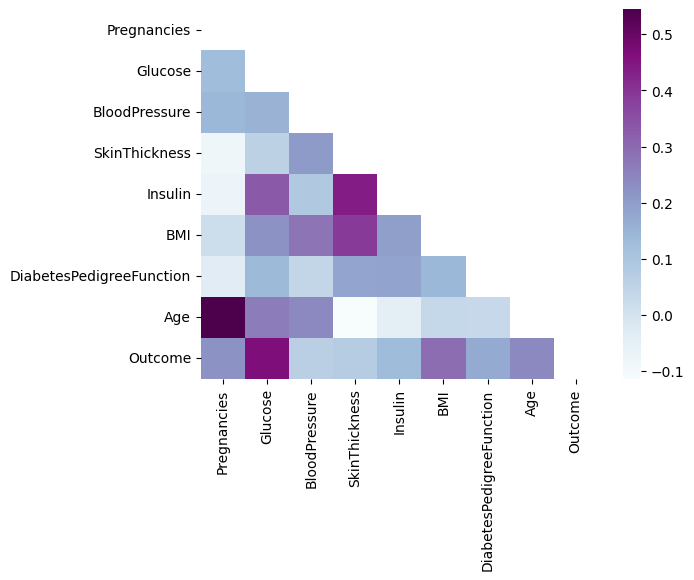

In [21]:
corr = data.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, mask=mask, cmap='BuPu')
plt.show()